### Data Cleaning / Exploration 

In [2]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
import ast
from typing import List
from os import listdir

In [3]:
# Read-in Personal Listening History. Depending on the size of your listening history, it could be in multiple files. Data comes in JSON format need to convert to csv. 

def get_streamings(path: str = 'MyData/') -> [dict]:
    files = [path + x for x in listdir(path)
             if x.split('.')[0][:-1] == 'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

streaming = get_streamings()
df = pd.DataFrame(streaming)

#df = pd.read_csv("StreamingHistory0.csv")
df.head()

,endTime,artistName,trackName,msPlayed
0,2021-03-27 19:31,ROSÉ,Gone,39929
1,2021-03-28 03:49,Fallen Roses,Laying Around,31093
2,2021-03-29 00:41,Kanye West,I Wonder,243440
3,2021-03-29 01:34,Miguel,waves - Tame Impala Remix,92666
4,2021-03-29 18:29,Riton,Friday (feat. Mufasa & Hypeman) - Dopamine Re-...,169153


In [4]:
#You can either have your streaming history downloaded or access your streaming history via the spotify api

In [5]:
# Renaming the column names
#df = df[["artistName","trackName", "msPlayed"]].drop_duplicates()
df = df.rename(columns={"artistName":"artist","endTime":"date","trackName":"track"})
#df
df_1 = df
df_1["secPlayed"] = df["msPlayed"]/1000
df_1

,date,artist,track,msPlayed,secPlayed
0,2021-03-27 19:31,ROSÉ,Gone,39929,39.929
1,2021-03-28 03:49,Fallen Roses,Laying Around,31093,31.093
2,2021-03-29 00:41,Kanye West,I Wonder,243440,243.440
3,2021-03-29 01:34,Miguel,waves - Tame Impala Remix,92666,92.666
4,2021-03-29 18:29,Riton,Friday (feat. Mufasa & Hypeman) - Dopamine Re-...,169153,169.153
...,...,...,...,...,...
8448,2022-03-29 20:41,Tai Verdes,3 outfits,210866,210.866
8449,2022-03-29 20:43,Nic D,Talladega,1447,1.447
8450,2022-03-29 20:43,Arizona Zervas,BAND$,108072,108.072
8451,2022-03-29 20:47,Louis The Child,Little Things (with Quinn XCII & Chelsea Cutler),197453,197.453


Text(0.5, 1.0, "Choosing what is a 'favorite' song")

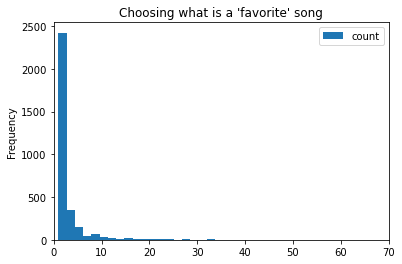

In [6]:
ax = df.groupby(['artist','track']).size().to_frame('count').reset_index().plot(kind='hist',bins=25)
ax.set_xlim(0,70)
ax.set_title("Choosing what is a 'favorite' song")

In [8]:
# Find number of occurences of each song, and keep songs with 15 or more listnes
df4 = df.groupby(['artist','track']).size().to_frame('count').reset_index()
#df1.head()
df3 = df.groupby(['artist','track'])['msPlayed'].sum().reset_index()

extracted_col1 = df4["count"]
#extracted_col2 = df4["count"]
df3 = df3.join(extracted_col1)
df3 = df3[df3['count']>=10]
# To display the top  rows
#df3.to_csv("test1.csv")
df3

In [ ]:
# Read-in Song Features dataset
features = pd.read_csv("SpotifyFeatures1.csv")
# renaming columns
features = features.rename(columns={"artist_name":"artist","track_name":"track"})
features.head(5)

In [10]:
# The 'favorite' column will be the variable that we try to predict (y).
# Create 'favorite' column (favorite = 1, not favorite = 0)
features['same_artists'] = features.artist.isin(df3.artist) 
features['same_track'] = features.track.isin(df3.track) 
#features["favorite"] = np.where((features["same_track"] == True),1,0) 
features["favorite"] = np.where((features["same_artists"] == True) & (features["same_track"] == True),1,0) # If both instances are True.
#features = features.drop(["same_track"],axis=1)
features = features.drop(["same_artists","same_track"],axis=1)

In [11]:
#Creating another metric to determine if a song is a favorite or not

df2 = features[features['favorite']==1]
df6  = pd.merge(df2, df3, on = ["track", "artist"], how = "inner")
df6 = df6.drop_duplicates(subset=["track", "artist"], keep= 'first')
#df6.drop('artist_y', axis=1, inplace=True)
#df6 = df6.rename(columns={"artist_x":"artist"})
df6["totalTimesPlayed"] = df6["msPlayed"]/df6["duration_ms"]
df6["totalSecPlayed"] = df6["msPlayed"]/1000

#all time percentage played
df6['durationSec'] = df6['duration_ms']/1000
#df6["allTimeDuration"] = df6["totalTimesPlayed"] *(df6["durationSec"])
df6["allTimePercent"] = df6["totalSecPlayed"]/(df6['durationSec']*df6['count'])

#narrow the favorites even more
df6 = df6[df6['allTimePercent']>=0.6]
features['same_artists'] = features.artist.isin(df6.artist)
features['same_track'] = features.track.isin(df6.track) 
features['newFav'] = np.where((features["same_artists"] == True) & (features["same_track"] == True),1,0)
features = features.drop(["same_artists","same_track", "favorite"],axis=1)
#f6.to_csv("test1.csv")
features
#features.to_csv("test.csv")

In [ ]:
# Genre 
#features.genre.unique()

In [40]:
#features

,genre,artist,track,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,favorite
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4-Apr,0.814,0
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4-Apr,0.816,0
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,4-May,0.368,0
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4-Apr,0.227,0
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4-Apr,0.390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4-Apr,0.962,0
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4-Apr,0.969,0
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4-Apr,0.813,0
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4-Apr,0.489,0


### Are comedy 'songs' actually songs?

In [41]:
#features[features.genre == 'Comedy'].describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,favorite
count,9681.000000,9681.000000,9681.000000,9.681000e+03,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.0
mean,21.342630,0.793098,0.559038,2.353052e+05,0.676094,0.000574,0.724775,-11.689321,0.853532,98.235488,0.412764,0.0
std,8.428764,0.130313,0.089625,2.502539e+05,0.211705,0.009987,0.223437,4.777983,0.205918,27.839986,0.207258,0.0
min,0.000000,0.000363,0.239000,3.004000e+04,0.001410,0.000000,0.025800,-31.047000,0.023000,32.451000,0.023700,0.0
25%,15.000000,0.753000,0.499000,1.218800e+05,0.522000,0.000000,0.662000,-14.649000,0.888000,79.720000,0.252000,0.0
50%,20.000000,0.819000,0.561000,1.890570e+05,0.704000,0.000000,0.767000,-11.209000,0.928000,90.124000,0.410000,0.0
75%,26.000000,0.872000,0.620000,2.812930e+05,0.859000,0.000000,0.898000,-8.088000,0.944000,115.128000,0.561000,0.0
max,61.000000,0.995000,0.898000,5.552917e+06,0.998000,0.352000,0.996000,-0.255000,0.967000,207.157000,0.980000,0.0


In [12]:
# Low instrumentalness + high liveness and speechiness probably indicates this catergory has minimal songs 
# Looks like the comedy songs are not actually songs so we get rid of it
features = features[features.genre!='Comedy']
#features[features.genre == 'Anime'].describe()

### Balancing Classes with Oversampling (SMOTE) and Feature Selection
Clearly the classes are very imbalanced meaning that the model would probably just predict that every song is not a favorite which would not be very useful. Oversampling from the minority class helps take care of that issue


In [13]:
# For future use
future = features.copy(deep=True)

In [14]:
# Shows how the classes are imbalanced
#eatures.favorite.value_counts()
features.newFav.value_counts()

0    222905
1       139
Name: newFav, dtype: int64

In [15]:
#For the SMOTE function to work, we need to drop any columuns that do not have strictly nubmers - this varies from dataset to dataset, so this part must be adjusted
#X = features.drop(columns=['favorite','artist','key','mode','time_signature','album', 'album_id', 'artist_ids','track_number', 'disc_number', 'explicit', 'year' , 'release_date', 'id', 'track'])
X = features.drop(columns=['artist','track','genre','track_id', 'key','mode','time_signature','duration_ms','newFav'])
y = features.newFav
oversample = SMOTE()
#labels = np.unique(y); print(labels)
X, y = oversample.fit_resample(X, y)
X['newFav'] = y
X.head()


,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,newFav
0,0,0.611,0.389,0.910,0.000,0.3460,-1.828,0.0525,166.969,0.814,0
1,1,0.246,0.590,0.737,0.000,0.1510,-5.559,0.0868,174.003,0.816,0
2,3,0.952,0.663,0.131,0.000,0.1030,-13.879,0.0362,99.488,0.368,0
3,0,0.703,0.240,0.326,0.000,0.0985,-12.178,0.0395,171.758,0.227,0
4,4,0.950,0.331,0.225,0.123,0.2020,-21.150,0.0456,140.576,0.390,0


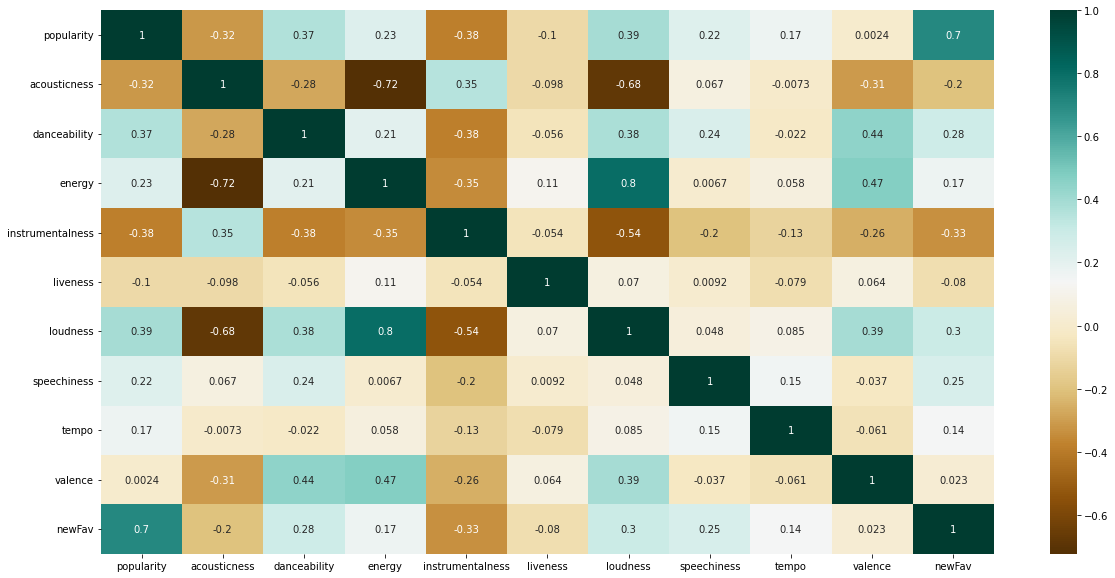

In [16]:
# Correlation Matrix of quantitative features. Looking at the bottom row we can see which features impact the chances that a song will be a favorite the most
plt.figure(figsize=(20,10))
c = X.corr()
corr = sns.heatmap(c,cmap="BrBG",annot=True)

### Model Selection with Cross-validation and Hyperparameter Optimization
We now test out three different classifier algorithims:Random Forest Classifier, Decision Tree Classifier, and Logistic Regression. The F1 score is used as the accuracy measure. 

In [17]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [18]:
# Train / Split Data
# X is the oversampled data, while y is simply which songs are classfied as favorites
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='newFav'), X.newFav,test_size = .20)
#X.favorite


In [ ]:
#%%time
# Logistic Regression consistantly performs slower than the other models so not even bothering to do this one
#lr = LogisticRegression()
#lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
#np.mean(lr_scores)

In [49]:
# Hyperparameter optimization for Decision Tree Classifier
#parameters = {
   # 'max_depth':[15,20,30],}
#dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
#dtc.fit(X_train, y_train)
#dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [19]:
%%time
# Decision Tree
dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

CPU times: user 45.4 s, sys: 5.01 ms, total: 45.4 s
Wall time: 45.4 s


0.9945096976264589

In [58]:
# Hyperparameter optimization of RandomForestClassifier
#parameters = {
    #'max_depth':[6,12,15,20],
    #'n_estimators':[20,30]}
#clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
#clf.fit(X_train, y_train)
#clf.named_steps['CV'].best_params_

{'max_depth': 20, 'n_estimators': 20}

In [20]:
%%time
# Cross-validation for RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 20))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

CPU times: user 2min 32s, sys: 4.49 ms, total: 2min 32s
Wall time: 2min 32s


0.9876198819546484

### Predicting Songs and Saving Dataset for Personal Use

In [21]:
# Use the F1 score to determine which model is the best. For this particular instance, the decision tree works the best

if np.mean(rf_scores) > np.mean(dt_scores):
    model = rf
else: 
    model = dt
model.fit(X_train, y_train)
prediction = model.predict(future.drop(columns=['artist','track','genre','track_id', 'key','mode','time_signature','duration_ms','newFav']))

In [22]:
future['prediction'] = prediction

In [23]:
# Gets only songs that were not favorites but are predicted to be
future = future[(future['newFav']==0) & (future['prediction'] == 1)]

In [24]:
future = future.drop(columns=['track_id', 'key','mode','time_signature','duration_ms', 'energy', 'danceability', 'loudness','liveness', 'valence','acousticness','speechiness', 'popularity','newFav','instrumentalness', 'tempo','prediction'])


In [25]:
future

,genre,artist,track
135,R&B,Mary J. Blige,Be Without You - Kendu Mix
148,R&B,TWENTY88,On The Way
165,R&B,MIKExANGEL,Complicated
167,R&B,Tory Lanez,S.w.I.n.G (feat. PnB Rock & Trey Songz)
202,R&B,Jason Derulo,Ridin' Solo
...,...,...,...
225146,Rock,OneRepublic,No Vacancy
225218,Rock,Arctic Monkeys,Stop The World I Wanna Get Off With You
226018,Rock,Jesse McCartney,Wasted
226151,Rock,YUNGBLUD,Polygraph Eyes


In [26]:
# Saving csv
#future.to_csv("recommendations.csv")
#sampled csv files since 1000s of recs are too much
sampled = future.sample(100)
#sampled
sampled.to_csv("100recs.csv")

In [ ]:
# creating spotify playlist from csv file
